In [24]:
import re
import unicodedata
import pandas as pd
import nltk
from wordcloud import WordCloud

from env import user, password, host, get_db_url

import acquire
import prepare

import warnings
warnings.filterwarnings('ignore')

In [2]:
url = get_db_url('spam_db', user, host, password)

In [3]:
sql = '''SELECT * FROM spam'''

## 1. Spam Data

### a. Load the spam data set.

In [4]:
df = pd.read_sql(sql,url, index_col='id')
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [5]:
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [6]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [7]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [8]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [9]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
2       173
u       155
txt     150
dtype: int64

In [10]:
ham_freq.head()

u       1027
im       449
get      314
2        305
ltgt     276
dtype: int64

In [11]:
all_freq.head()

u       1182
call     600
2        478
im       462
get      397
dtype: int64

In [12]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [14]:
word_counts.sort_values(by='all', ascending=False).head(20)

,all,ham,spam
u,1182,1027,155
call,600,241,359
2,478,305,173
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5


In [15]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(10),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(10)])

,all,ham,spam
amp,82,82,0
said,86,86,0
ask,88,88,0
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
ltgt,276,276,0


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# prep
ham_words = prepare.basic_clean(' '.join(df[df.label == 'ham'].text))
ham_words = prepare.tokenize(ham_words)
ham_words = prepare.remove_stopwords(ham_words)
ham_words = prepare.lemmatize(ham_words)

spam_words = prepare.basic_clean(' '.join(df[df.label == 'spam'].text))
spam_words = prepare.tokenize(spam_words)
ham_words = prepare.remove_stopwords(ham_words)
spam_words = prepare.lemmatize(spam_words)

all_words = ham_words + spam_words

In [20]:
# split
ham_bis = list(nltk.ngrams(ham_words.split(), 2))
spam_bis = list(nltk.ngrams(spam_words.split(), 2))
all_bis = list(nltk.ngrams(all_words.split(), 2))

In [21]:
ham_bi_counts = pd.concat([pd.Series(ham_bis).value_counts()])
spam_bi_counts = pd.concat([pd.Series(spam_bis).value_counts()])
all_bi_counts = pd.concat([pd.Series(all_bis).value_counts()])

bi_counts = (pd.concat([ham_bi_counts, spam_bi_counts, all_bi_counts], axis=1)
               .set_axis(['ham', 'spam', 'all'], axis=1, inplace=False) 
             .fillna(0).apply(lambda s: s.astype(int)).sort_values(by='all', ascending=False))
bi_counts

,,ham,spam,all
you,have,0,73,73
have,won,0,54,54
please,call,9,44,53
call,later,52,0,52
your,mobile,0,49,49
...,...,...,...,...
say,everything,1,0,1
gave,pain,1,0,1
doc,gave,1,0,1
true,namefree,0,0,1


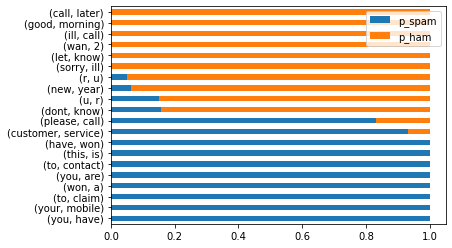

In [22]:
(bi_counts
 .assign(p_spam=bi_counts.spam / bi_counts['all'],
         p_ham=bi_counts.ham / bi_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))
plt.show()

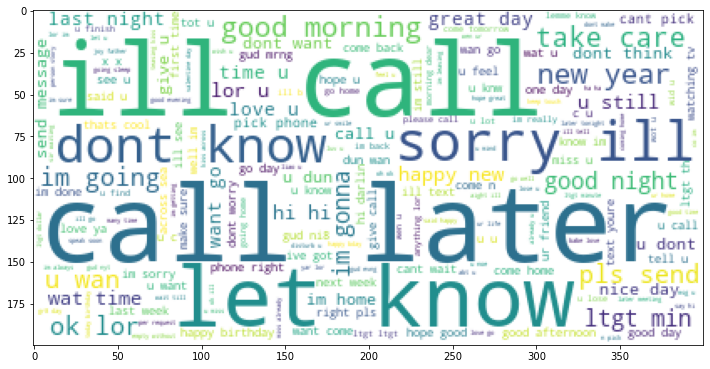

In [28]:
# ham bigrams
plt.figure(figsize=(12,8))
img = WordCloud(background_color='white',
                collocation_threshold = 3).generate(ham_words)
plt.imshow(img)
plt.show()

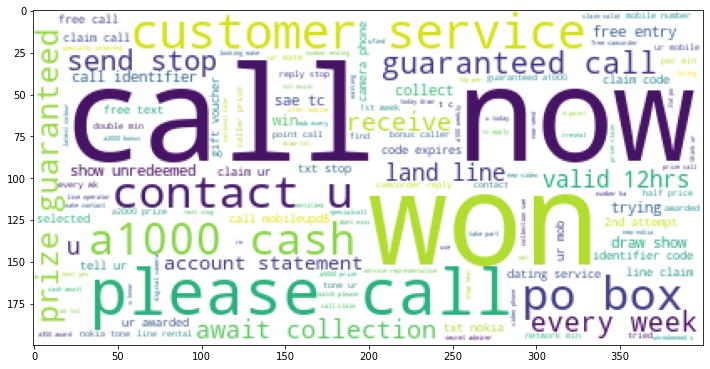

In [29]:
# ham bigrams
plt.figure(figsize=(12,8))
img = WordCloud(background_color='white',
                collocation_threshold = 3).generate(spam_words)
plt.imshow(img)
plt.show()